In [1]:
using LightGraphs, GraphPlot, GraphRecipes, Plots, TreeView, AbstractTrees, DataStructures, Images

# Search Tree Optimization With $\alpha, \beta$ Pruning

Isaac Hawn

### A Preliminary Overview of Minimax

The minimax problem is a sub-problem of search tree optimization in which two "players" participate in a game alternating their turns at each depth. One of these players is attempting to maximize a given node and the other is attempting to minimize it, usually on a zero-sum basis. Minimax also assumes that if a decision benefits one player, it is disadvantageous to the other.

As a tree traversal algorithm, minimax is often implemented recursively with a depth check on each call. At the final depth, a static evaluation of the game state is computed and returned up the tree until all nodes are populated.

In [2]:
function GenerateMinimaxNodes(depth, lst)
    if depth == 1
        push!(lst, randn())
        push!(lst, randn())
        return lst
    else
        lst2 = GenerateMinimaxNodes(depth-1, [])
        push!(lst, lst2)

        lst2 = GenerateMinimaxNodes(depth-1, [])
        push!(lst, lst2)
        
        return lst
    end
end

GenerateMinimaxNodes (generic function with 1 method)

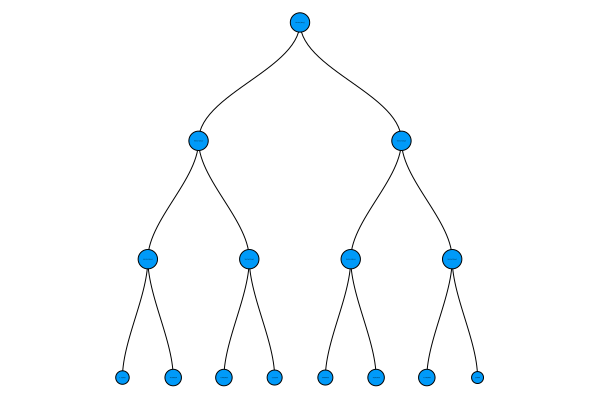

In [3]:
depth = 3
tree = GenerateMinimaxNodes(depth, [])
plot(TreePlot(tree), root=:top, node_shape=:circle, fontsize=1, nodesize=0.2, axis_buffer=0.03)

In [4]:
[-1, 3, 5, 1, -6, -4, 0, 9]

8-element Vector{Int64}:
 -1
  3
  5
  1
 -6
 -4
  0
  9

Determining the number of leaves on a game tree is a fairly straightforward counting problem. Given a game with $b$ possible moves at the game start, a tree search of depth $d$ will result in

$$
\sum_{i=1}^d \frac{b!}{(b-i)!}
$$

game state evaluations. This formulation assumes that each move from one player removes a potential move of the other player. If instead we assume that the game has a constant move count per player per turn, the number of board evaluations simply becomes

$$
\sum_{i=1}^d b^i
$$

Of course, $b$ might change from turn to turn depending on the situation. For example a chess game will have a highly variable number of possible moves per turn. In either case, the problem size grows quite rapidly.

### A Major Optimization For Pure Minimax



In terms of time complexity for the latter case, we are looking at the exponential complexity $O(b^d)$ which means that pure minimax has some serious time constraints. We may mitigate this shortcoming significantly using a tree pruning technique known as $\alpha$, $\beta$ pruning which is in the branch and bound class of algorithm.

The idea is fairly straightforward. If we assume that our oponent always moves optimally, we will usually reach a point in which certain branch trees need not be considered. For example, consider the following minimax tree:

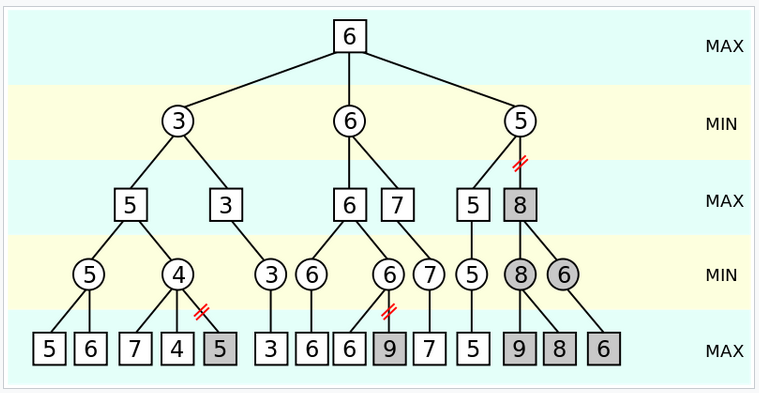

In [5]:
IJulia.display("image/png", read("wikipedia_pruning_image.png")) # https://en.wikipedia.org/wiki/Alpha%E2%80%93beta_pruning#/media/File:AB_pruning.svg

If we look at this from the perspective of the maximizing player, we can see branches which will not affect the outcome due to the order in which they were evaluated. Thus, they may be pruned.

Of course, it is possible that no branches may be pruned but if the specific game is taken into consideration, we may order prospective moves based off of how "good" we expect them to be. Going back to the chess example, if a low ranking piece were to caputure a high ranking piece, this is very likely to be a good move so we could consider it first.

For a poorly ordered tree, meaning that the worst moves are always searched first, no pruning will be possible, leading to a time complexity the same as pure minimax, that is $O(b^d)$.

However, if the best moves are always searched first, we may expect a time complexity of $O\left(b^{d/2}\right)$, a significant improvement. This is improvement becomes especially apparent for large depth. In any case, this best case scenerio essentially means that we can search twice as deep for the same amount of work.

Rarely can we expect this situation but even a random ordering of moves will almost certainly result in large improvments. For example, consider the following simple implementation:

In [6]:
#pure minimax
function Minimax(tree, depth, isMaximizer)
    if depth == 0
        return tree[1]
    else
        if isMaximizer
            val = -Inf
            for i = 1:length(tree)
                val = max(val, Minimax(tree[i], depth-1, false))
            end
            return val
        else
            val = Inf
            for i = 1:length(tree)
                val = min(val, Minimax(tree[i], depth-1, true))
            end
            return val
        end
    end
end

#minimax with α, β pruning
function Minimax_ab(tree, depth, isMaximizer, α, β)
    if depth == 0
        return tree[1]
    else
        if isMaximizer
            val = -Inf
            i = 1
            while i <= length(tree) && val < β
                val = max(val, Minimax_ab(tree[i], depth-1, false, α, β))
                α = max(α, val)
                i += 1
            end
            return val
        else
            val = Inf
            i = 1
            while i <= length(tree) && val > α
                val = min(val, Minimax_ab(tree[i], depth-1, true, α, β))
                β = min(β, val)
                i += 1
            end
            return val
        end
    end
end

#tree generation
function GenerateMinimaxNodesMulti(depth, lst, child_count)
    if depth == 1
        for i in 1:child_count
            push!(lst, randn())
        end      
        return lst
    else
        for i in 1:child_count
            lst2 = GenerateMinimaxNodes(depth-1, [])
            push!(lst, lst2)   
        end
        return lst
    end
end

GenerateMinimaxNodesMulti (generic function with 1 method)

In [22]:
depth = 15
child_count = 10
tree = GenerateMinimaxNodesMulti(depth, [], child_count)
[@time Minimax(tree, depth, true); @time Minimax_ab(tree, depth, true, -Inf, Inf)]

  0.018940 seconds (491.51 k allocations: 7.500 MiB)
  0.003949 seconds (155.81 k allocations: 2.377 MiB)


2-element Vector{Float64}:
 0.40347814727588893
 0.40347814727588893

In [12]:
#benchmark

mm_time = Float64[]
ab_time = Float64[]

for d = 2:22
    tree = GenerateMinimaxNodesMulti(d, [], child_count)
    
    ave = 0
    for i = 1:3
        ave += @elapsed Minimax(tree, d, true)
    end
    append!(mm_time, ave/3)
    
    ave = 0
    for i = 1:3
        ave += @elapsed Minimax_ab(tree, d, true, -Inf, Inf)
    end
    append!(ab_time, ave/3)
end

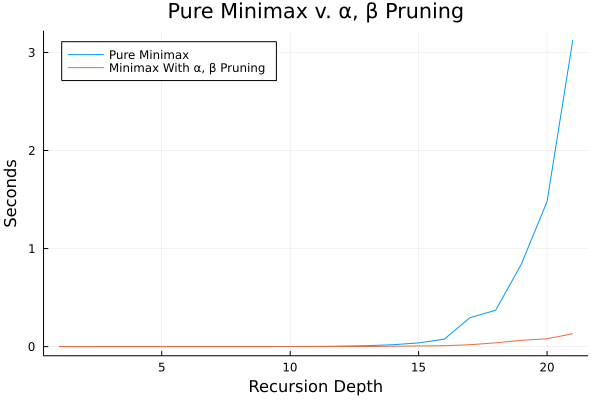

In [15]:
plot(mm_time, title = "Pure Minimax v. α, β Pruning", label = "Pure Minimax", legend=:topleft, xlabel = "Recursion Depth", ylabel = "Seconds")
plot!(ab_time, label = "Minimax With α, β Pruning")

Here we see just how powerfull $\alpha$, $\beta$ pruning can be, even with a random move ordering.

Sources:

Dr. Krislock

Heineman, Pollice, and Selkow's $\textit{Algorithms in a Nutshell}$

https://en.wikipedia.org/wiki/Alpha%E2%80%93beta_pruning

Sebastian Lague